In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as c
m_e=c.m_e/c.m_u

In [2]:
#CGS for v, n, eV for T, m in atomic mass units
#test particle a slows on a field of particles b
#nu_ab is not equal to nu_ba!!!
class Particle:
    def __init__(self, m, Z, v, T, n):
        self.m=float(m)
        self.m_g=m*c.m_u*1e3 #convert to grams
        self.T_erg=T*c.e*1e7#convert to ergs
        self.T=float(T)
        self.Z=Z
        self.v_T=np.sqrt(self.T_erg/self.m_g)
        if v==None:
            self.v=self.v_T
        else:
            self.v=float(v)
        self.n=float(n)
        self.e=Z*4.8e-10#in stat coloumbs
        
def x_ab(a,b):
    return b.m_g*a.v**2/(2*b.T_erg)
    
def col_log(a,b, T_e=None):
    if a.Z is -1 and b.Z is -1:#electron electron
        print('Electron-Electron')
        return 23.5-np.log(a.n**0.5*a.T**-1.25)-(1e-5+((np.log(a.T-2))**2)/16.0)**0.5
    if a.Z is not -1 and b.Z is not -1: #ion ion
        v_D=np.abs(a.v-b.v)       
        if a.v_T<v_D and b.v_T<v_D:
            print('Counter-streaming ions')
            beta_D=v_D/(c.c*1e2)
            n_e=a.Z*a.n+b.Z*b.n
            return 43-np.log(a.Z*b.Z*(a.m+b.m)/(a.m*b.m*beta_D**2)*(n_e/T_e)**0.5)
        else:
            print('Mixed ion-ion')
            return 23-np.log(a.Z*b.Z*(a.m+b.m)/(a.m*a.T+b.m*b.T)*(a.n*a.Z**2/a.T+b.n*b.Z**2/b.T)**0.5)
    else: #electron ion
        if a.Z is -1:
            el=a
            io=b
            print('b is ion, a is electron')
        else:
            el=b
            io=a
            print('a is ion, b is electron')
        #Define the three 'decision temperatures'
        Te=el.T
        Ti=io.T*el.m/io.m
        TZ=10*io.Z**2
        if Ti<Te and Te<TZ: #see NRL formulary pg 34
            print('Ion-Electron, T_i*m_e/m_i<T_e<10 Z^2')
            return 23-np.log(el.n**0.5*io.Z*el.T**-1.5)
        elif Ti<TZ and TZ<Te:
            print('Ion-Electron, T_i*m_e/m_i<10 Z^2<T_e')
            return 24-np.log(el.n**0.5*el.T**-1.0)
        elif Tie<io.Z*Ti:
            print('Ion-Electron, T_i*m_e/m_i<10 Z^2<T_e')
            return 30-np.log(io.n**0.5*io.T**-1.5*io.Z**2/io.m)
        else:
            print('Ion-Electron: Whoops! You broke Physics!!!')
            return 2

        
def nu_0(a,b, T_e=None):
    return 4*np.pi*a.e**2*b.e**2*col_log(a,b, T_e)*b.n/(a.m_g**2*np.abs(a.v)**3)

def psi(x, steps=1e3):
    t=np.linspace(0, x, steps)
    integrand=t**0.5*np.exp(-t)
    return 2/np.sqrt(np.pi)*np.trapz(integrand, x=t)

def psi_prime(x):
    return 2/np.sqrt(np.pi)*x**0.5*np.exp(-x)

def nu_slowing(a,b, T_e=None):
    xab=x_ab(a,b)
    pab=psi(xab)
    return (1+a.m/b.m)*pab*nu_0(a,b, T_e)

def nu_transverse(a,b, T_e=None):
    xab=x_ab(a,b)
    pab=psi(xab)
    ppab=psi_prime(xab)
    return 2*((1-1/(2*xab))*pab+ppab)*nu_0(a,b, T_e)

def nu_parallel(a,b, T_e=None):
    xab=x_ab(a,b)
    pab=psi(xab)
    return (pab/xab)*nu_0(a,b, T_e)

def nu_energy(a,b, T_e=None):
    xab=x_ab(a,b)
    pab=psi(xab)
    ppab=psi_prime(xab)
    return 2*((a.m/b.m)*pab-ppab)*nu_0(a,b, T_e)

def l_slowing(a,b, T_e=None):
    return a.v/nu_slowing(a,b,T_e)

def l_parallel(a,b, T_e=None):
    return a.v/nu_parallel(a,b,T_e)

def l_transverse(a,b, T_e=None):
    return a.v/nu_transverse(a,b,T_e)

def l_energy(a,b, T_e=None):
    return a.v/nu_energy(a,b,T_e)
    

# Calculate collision frequencies and lengths

In [9]:
#The temperature and density of background particles b and the velocity of test particles a are the important quantities,
#along with m and Z for both particles.
C=Particle(m=12, Z=4, T=50, v=None,n=1e18/6)
Al=Particle(m=27, Z=7.5, T=300, v=None,n=3e17)
W=Particle(m=138, Z=12, T=20e3, v=3e6,n=1e16)
el=Particle(m=m_e, Z=-1, T=45, v=None,n=3e18)
print(l_transverse(C,C)*1e4)

Mixed ion-ion
0.513663565285


In [9]:
C.m/el.m        

21874.66181724048

# Finding Critical Velocity for Energy Loss/Gain

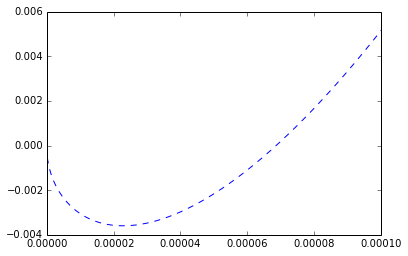

In [114]:
x=np.linspace(0,1e-4,1e3) #adjust second argument to get range in which we can determine x_star easily.
vp=np.vectorize(psi)
diff=(a.m/b.m)*vp(x,steps=1e5)-psi_prime(x)
plt.plot(x, diff, '--')

In [118]:
cross_over_index=np.where(diff>0)[0][0]
x_star=x[cross_over_index]
e_star=b.T_erg*x_star*(a.m/b.m)
v_star=np.sqrt(2*e_star/a.m_g)
print v_star

1554193.25607


In [165]:
C.m_g/1.66e-24/12

1.0003246512048192